# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 


# Start

In [93]:
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:ScottPlot"

using System;
using System.Reflection;

using Microsoft.DotNet.Interactive.Formatting;

using Microsoft.Data.Analysis;

using Newtonsoft.Json;

bool DEBUG = true;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

In [94]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);

class PlotBuilder {
    ScottPlot.Plot plot;

    public PlotBuilder (string title = "") {
        plot = new ();
        plot.Axes.Title.Label.Text = title;
    }

    public PlotBuilder Add<T1, T2> (List<T1> x, List<T2> y, string legend = default) {
        plot.Add.Scatter(x, y).LegendText = legend ?? "";
        return this;
    }
    public PlotBuilder Add<T> (List<T> y, string legend = default) => Add(Enumerable.Range(0, y.Count).ToList(), y, legend);
    public PlotBuilder Add<T> (List<(T,T)> y, (string, string) legend = default) =>
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2);
    public PlotBuilder Add<T> (List<(T,T,T)> y, (string, string, string) legend = default) => 
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2)
        .Add(y.Select(y => y.Item3).ToList(), legend.Item3);

    public PlotBuilder LimitY(double y0, double y1) {
        plot.Axes.SetLimitsY(y0, y1);
        return this;
    } 
    public PlotBuilder Limit(double x0, double x1, double y0, double y1) {
        plot.Axes.SetLimits(x0, x1, y0, y1);
        return this;
    }
    public PlotBuilder LimitH(double h) => LimitY(0, h); 

    public ScottPlot.Plot Build ()  {  
        plot.Axes.SetLimits(0, 1000);
        return plot; 
    }
}

In [95]:
static string DumpS(this object value) => value is not string ? JsonConvert.SerializeObject(value, Formatting.None) : value as string;

static T[] DumpMulti<T> (this T[] values) {
    values.ToList().ForEach(item => item.Dump());
    return values;  
} 
static IEnumerable<T> DumpMulti<T> (this IEnumerable<T> values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static T Dump<T>(this T value) => DumpOneLine(value);

static T DumpOneLine<T> (this T value) {
    Console.WriteLine(value.DumpS());
    return value;
}
static void Log(this object item) => Console.WriteLine(item);

In [96]:
static BindingFlags flags = BindingFlags.Public | BindingFlags.Instance;

static DataFrame CreateDataFrame (IEnumerable<object> values) {
    Type type = values.First().GetType();

    if (type.IsPrimitive)
        return DataFrame.LoadFrom(values.Select(i => new List<object>() { i }), new List<(string, Type)>() { ("", type)});

    FieldInfo[] fields = type.GetFields(flags);
    PropertyInfo[] properties = type.GetProperties(flags);

    IEnumerable<DataFrame> dataFields = fields.Select(field => CreateDataFrame(values.Select(field.GetValue)).AddPrefix($"{field.Name} ", inPlace: true));
    IEnumerable<DataFrame> dataProperties = properties.Select(property => CreateDataFrame(values.Select(property.GetValue)).AddPrefix($"{property.Name} ", inPlace: true));
    IEnumerable<DataFrameColumn> columns = new [] { dataFields, dataProperties }.SelectMany(frames => frames).SelectMany(frame => frame.Columns);
    return new DataFrame(columns);
}
static DataFrame CreateDataFrame<T> (IEnumerable<T> values) => CreateDataFrame(values.Select(i => (object)i));

static DataFrame ToDataFrame<T1, T2, T3>(this List<(T1, T2, T3)> objects, string p1 = "",  string p2 = "", string p3 = "") {
    var df1 = objects.Select(i => i.Item1).ToDataFrame(p1);
    var df2 = objects.Select(i => i.Item2).ToDataFrame(p2);
    var df3 = objects.Select(i => i.Item3).ToDataFrame(p3);
    return df1.Concat(df2).Concat(df3);
} 
static DataFrame ToDataFrame<T1, T2, T3, T4>(this List<(T1, T2, T3, T4)> objects, string p1 = "",  string p2 = "", string p3 = "", string p4 ="") {
    var df1 = objects.Select(i => i.Item1).ToDataFrame(p1);
    var df2 = objects.Select(i => i.Item2).ToDataFrame(p2);
    var df3 = objects.Select(i => i.Item3).ToDataFrame(p3);
    var df4 = objects.Select(i => i.Item4).ToDataFrame(p4);
    return df1.Concat(df2).Concat(df3).Concat(df4);
} 
static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, string prefix = "")    => CreateDataFrame(objects.ToList()).AddPrefix(prefix, inPlace: true); 
static DataFrame ToDataFrame<T>(this List<T> objects, string prefix = "")           => CreateDataFrame(objects).AddPrefix(prefix, inPlace: true); 
static DataFrame Concat(this DataFrame df, DataFrame added, string prefix = "" )    => new DataFrame(df.Columns.Concat(added.Clone().AddPrefix(prefix).Columns));

In [99]:
Random random = new Random(29);

float NextGauss (float mean, float stdDev) {
    float u1 = 1.0f - random.NextSingle();
    float u2 = 1.0f - random.NextSingle();
    float randStdNormal = (float)Math.Sqrt(-2.0f * Math.Log(u1)) * (float)Math.Sin(2.0f * Math.PI * u2); 
    float randNormal = mean + stdDev * randStdNormal; 
    return randNormal;
}
float NextGauss (float mu, float sigma, float min, float max) {
    float x;
    do
    {
        x = NextGauss(mu, sigma);
    } while (x < min || x > max);

    return x;
}

# Simulation

In [100]:
public partial struct Market
{
    public uint Food, Oxygen, Minerals, Water;
}

public partial struct MarketF
{
    public float Food, Oxygen, Minerals, Water;
}

public struct Population
{
    public uint Farmers, Laborers, Engineers;
    public uint Children;
    public uint Total => Farmers + Laborers + Engineers + Children;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}

public struct Points 
{
    public int Value;
}

In [101]:
static Market sub(Market a, Market b) => new Market
    {
        Food     = a.Food     - b.Food,
        Oxygen   = a.Oxygen   - b.Oxygen,
        Minerals = a.Minerals - b.Minerals,
        Water    = a.Water    - b.Water
    };
static MarketF divF(Market a, Market b) => new MarketF
    {
        Food     = (float) a.Food     / b.Food,
        Oxygen   = (float) a.Oxygen   / b.Oxygen,
        Minerals = (float) a.Minerals / b.Minerals,
        Water    = (float) a.Water    / b.Water
    };
static Market min (Market a, Market b) => new Market
    {
        Food     = Math.Min(a.Food,     b.Food),
        Oxygen   = Math.Min(a.Oxygen,   b.Oxygen),
        Minerals = Math.Min(a.Minerals, b.Minerals),
        Water    = Math.Min(a.Water,    b.Water)
    };
static uint sum (this Population a) => a.Farmers + a.Laborers + a.Engineers + a.Children; 

In [102]:
void Build(in Population population, out Market market)
{
    market.Food = population.Farmers* 5;
    market.Minerals = population.Laborers;
    market.Oxygen = population.Engineers * 100;
    market.Water = population.Engineers * 20;
}

In [103]:
void Births (float deathRate, ref Population population) {
    float decrease = Math.Clamp(1 - deathRate, 0.8f, 1);
    float increase = 0.02f;//Math.Clamp(NextGauss(0.0002f, 0.0001f), 0, 0.01f);

    population.Children = (uint) (population.sum() * increase);

    population.Farmers   = (uint)(population.Farmers   * decrease);
    population.Laborers  = (uint)(population.Laborers  * decrease);
    population.Engineers = (uint)(population.Engineers * decrease);
} 

In [104]:
void Promote (in MarketF ratios, ref Population population) {
    // demand
    /*
    if (ratios.Oxygen < 1.2 || ratios.Water < 1.2) {
        uint p = (uint) (population.Farmers * 0.1f);
        population.Farmers -= p;
        population.Engineers += p;
    }*/

    // children
    if (ratios.Oxygen < 1 || ratios.Water < 1)
        population.Engineers += population.Children;
    else if (ratios.Food < 1)
        population.Farmers += population.Children;
    else
        population.Laborers += population.Children;
}

In [105]:
void Consume(in Market market, ref Population population, out MarketF ratio, out Market surplus)
{
    uint pops = population.sum();
    
    Market need = new();
    need.Oxygen = pops * 2;
    need.Food   = pops;
    need.Water  = pops;

    Market bought = min(market, need);

    surplus = sub(market, bought);

    ratio = divF(bought, need);
}


In [106]:
Market market;
Market surplus;
MarketF ratio;
Population population = new Population { Engineers = 10, Farmers = 10, Laborers = 1000 };

void SimulateStep () {
    Build(in population, out market);
    Consume(in market, ref population, out ratio, out surplus);
    Promote(in ratio, ref population);
    Births(1 - ratio.Oxygen, ref population);
}

// log
List<(Population, Market, Market)> steps = new();
List<(int, Population, Population, Market)> declines = new();

for (int i = 0; i < 1000; i++) {
    Population populationBefore = population;

    SimulateStep();

    steps.Add((population, market, surplus));
    
    if (population.sum() >= populationBefore.sum())
        continue;

    declines.Add((i, populationBefore, population, market));
    $"Population Shrinking from [{populationBefore.sum():E1} to {population.sum():E1}], children {population.Children:E1}, O2 {ratio.Oxygen:0.00}".Dump();//*/
}
new object[] {$"Simulation Completed with {declines.Count} declines", population, market}.DumpOneLine();

List<Population> populations = steps.Select(i => i.Item1).ToList();

Population Shrinking from [1.0E+003 to 8.4E+002], children 2.0E+001, O2 0.49
Population Shrinking from [8.4E+002 to 6.9E+002], children 1.7E+001, O2 0.48
Population Shrinking from [8.8E+008 to 8.4E+008], children 1.8E+007, O2 0.94
Population Shrinking from [1.5E+009 to 1.2E+009], children 3.0E+007, O2 0.51
Population Shrinking from [1.2E+009 to 9.9E+008], children 2.5E+007, O2 0.76
Population Shrinking from [2.1E+009 to 2.0E+009], children 4.3E+007, O2 0.90
Population Shrinking from [2.0E+009 to 1.6E+009], children 4.0E+007, O2 0.45
Population Shrinking from [1.6E+009 to 1.3E+009], children 3.3E+007, O2 0.44
Population Shrinking from [1.3E+009 to 1.1E+009], children 2.7E+007, O2 0.34
Population Shrinking from [2.1E+009 to 2.1E+009], children 4.4E+007, O2 0.96
Population Shrinking from [2.1E+009 to 1.7E+009], children 4.3E+007, O2 0.71
Population Shrinking from [1.7E+009 to 1.4E+009], children 3.5E+007, O2 0.45
Population Shrinking from [1.4E+009 to 1.2E+009], children 2.9E+007, O2 0.13


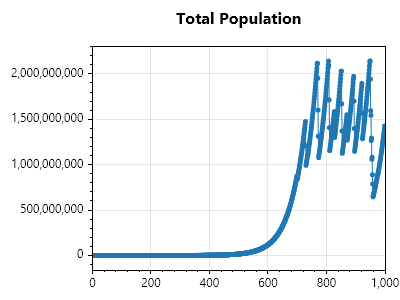

In [107]:
new PlotBuilder("Total Population").Add(populations.Select(pop => pop.sum()).ToList()).Build()


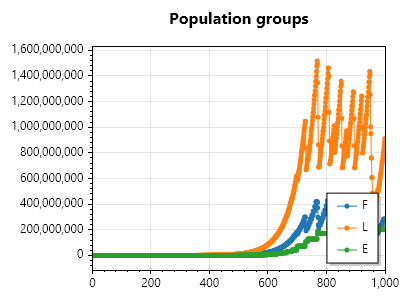

In [108]:
new PlotBuilder("Population groups").Add(populations.Select(pop => (pop.Farmers, pop.Laborers, pop.Engineers)).ToList(), ("F", "L", "E")).Build()


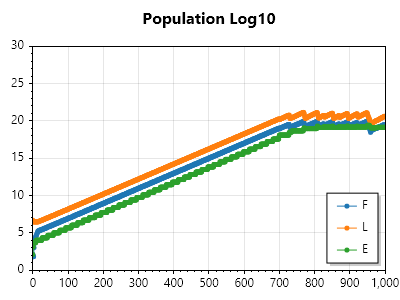

In [109]:
new PlotBuilder("Population Log10").Add(populations.Select(pop => (Math.Log(pop.Farmers), Math.Log(pop.Laborers), Math.Log(pop.Engineers))).ToList(), ("F", "L", "E")).LimitH(30).Build()

In [110]:
steps.ToDataFrame(p3: "s")

"Submission#102+Population, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null"
"Submission#102+Market, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null"
"Submission#102+Market, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null"


index,Farmers,Laborers,Engineers,Children,Total,Food,Oxygen,Minerals,Water,sFood,sOxygen,sMinerals,sWater
0,8,800,8,20,836,50,1000,1000,200,0,0,1000,0
1,6,640,22,17,685,40,800,800,160,0,0,800,0
2,6,640,39,14,699,30,2200,640,440,0,830,640,0
3,20,640,39,14,713,30,3900,640,780,0,2502,640,81
4,34,640,39,14,727,100,3900,640,780,0,2474,640,67
5,48,640,39,14,741,170,3900,640,780,0,2446,640,53
6,62,640,39,15,756,240,3900,640,780,0,2418,640,39
7,77,640,39,15,771,310,3900,640,780,0,2388,640,24
8,92,640,39,15,786,385,3900,640,780,0,2358,640,9
9,92,640,54,16,802,460,3900,640,780,0,2328,640,0


In [112]:
declines.ToDataFrame(p3: "-")

"System.Int32, System.Private.CoreLib, Version=8.0.0.0, Culture=neutral, PublicKeyToken=7cec85d7bea7798e"
"Submission#102+Population, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null"
"Submission#102+Population, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null"
"Submission#102+Market, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null"


index,i,Farmers,Laborers,Engineers,Children,Total,-Farmers,-Laborers,-Engineers,-Children,-Total,Food,Oxygen,Minerals,Water
0,0,10,1000,10,0,1020,8,800,8,20,836,50,1000,1000,200
1,1,8,800,8,20,836,6,640,22,17,685,40,800,800,160
2,700,178884448,619292928,59348540,17493390,875019306,167625008,580313024,72005296,17850254,837793582,894422240,1639886704,619292928,1186970800
3,729,298720864,1045649280,100899128,29483260,1474752532,238976688,836519424,104305912,30084714,1209886738,1493604320,1499978208,1045649280,2017982560
4,730,238976688,836519424,104305912,30084714,1209886738,191181360,669215552,107512504,24799428,992708844,1194883440,1840656608,836519424,2086118240
5,770,412222176,1495335680,167024320,42941972,2117524148,371582688,1347915904,189266464,43209324,1951974380,2061110880,3817530112,1495335680,3340486400
6,771,371582688,1347915904,189266464,43209324,1951974380,297266144,1078332800,185980640,39903672,1601483256,1857913440,1746777216,1347915904,3785329280
7,772,297266144,1078332800,185980640,39903672,1601483256,237812912,862666240,180707456,32827736,1314014344,1486330720,1418194816,1078332800,3719612800
8,773,237812912,862666240,180707456,32827736,1314014344,190250336,690132992,170828160,26936842,1078148330,1189064560,890876416,862666240,3614149120
9,808,425764128,1460457728,212735120,42832276,2141789252,406885536,1395700352,244235408,43692432,2090513728,2128820640,4093642816,1460457728,4254702400


In [113]:
declines.Select(i => i.Item1).ToList().ToDataFrame()

"System.Int32, System.Private.CoreLib, Version=8.0.0.0, Culture=neutral, PublicKeyToken=7cec85d7bea7798e"


index,i
0,0
1,1
2,700
3,729
4,730
5,770
6,771
7,772
8,773
9,808


In [114]:
new List<(Population, Market)> values = new () {default((Population, Market))};
values.ToDataFrame()

"System.ValueTuple`2[[Submission#102+Population, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null],[Submission#102+Market, ℛ*42e1af36-d0c2-4c47-97eb-9aece7237295#1-102, Version=0.0.0.0, Culture=neutral, PublicKeyToken=null]], System.Private.CoreLib, Version=8.0.0.0, Culture=neutral, PublicKeyToken=7cec85d7bea7798e"


Error: System.NotSupportedException: kind
   at Microsoft.Data.Analysis.DataFrame.LoadFrom(IEnumerable`1 vals, IList`1 columnInfos)
   at Submission#89.CreateDataFrame[T](List`1 objects, Boolean getProperties)
   at Submission#98.ToDataFrame[T](List`1 objects, String prefix)
   at Submission#116.<<Initialize>>d__0.MoveNext()
--- End of stack trace from previous location ---
   at Microsoft.CodeAnalysis.Scripting.ScriptExecutionState.RunSubmissionsAsync[TResult](ImmutableArray`1 precedingExecutors, Func`2 currentExecutor, StrongBox`1 exceptionHolderOpt, Func`2 catchExceptionOpt, CancellationToken cancellationToken)